# Timeseries Survival Analysis Tutorial

This notebook aims to demonstrate how to perform survival analysis in the context of PV assets, using the methodology from https://ieeexplore.ieee.org/document/9272625/. As outlined in that paper, survival analysis is concerned with estimating the failure rate over the lifetime of a system, given discrete observed failure events.

Gunda et al. used two methods: Kaplan-Meier estimation and fitting a Weibull distribution. We will do both here.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pvops import timeseries

## Loading and preprocessing data

### Reading in data

We read in the data below, where each column reflects data from an O&M (operation and maintenance) ticket. Note the following column descriptions:

- `randid` is an integer identifying the PV site

- `COD` identifies the commissioning date of the site

- `EventStart` is the recorded time of the event

- `Asset` identifies the asset involved in the event

In [2]:
om_df = pd.read_csv('example_data/example_om_survival_analysis_data.csv')
om_df.head(5)

,randid,COD,EventStart,Asset
0,0,2015-09-24,2016-05-18 09:00:00,Other
1,1,2014-08-01,2016-06-13 09:00:00,Other
2,2,2011-12-27,2016-11-10 09:00:00,Other
3,3,2015-07-22,2016-11-10 09:00:00,Other
4,4,2015-08-13,2016-11-24 09:00:00,Other


### Data preprocessing

As a first step, we can calculate the days until the event was observed.

In [3]:
om_df['days_until_failure'] = (pd.to_datetime(om_df['EventStart']) - pd.to_datetime(om_df['COD'])).dt.days
om_df.head(5)

,randid,COD,EventStart,Asset,days_until_failure
0,0,2015-09-24,2016-05-18 09:00:00,Other,237
1,1,2014-08-01,2016-06-13 09:00:00,Other,682
2,2,2011-12-27,2016-11-10 09:00:00,Other,1780
3,3,2015-07-22,2016-11-10 09:00:00,Other,477
4,4,2015-08-13,2016-11-24 09:00:00,Other,469


Without knowing more about the nature of the observed events, we will only consider the first event for a given asset type for each site.

If a given site-asset pair wasn't observed in the dataset, we can still glean information from the lack of a failure: we call this a right-censored datapoint. For these right-censored datapoints, we can take the last point we know the site was recording data (i.e., the latest timestamp for that site) and use that time as our datapoint. Then we just mark those datapoints as censored.

The function `pvops.timeseries.preprocess.identify_right_censored_data` performs this preprocessing step for us. We can see the result below:

In [4]:
censored_om_df = timeseries.preprocess.identify_right_censored_data(om_df, {'group_by': 'Asset', 'site': 'randid'})
censored_om_df.head(10)

COD           EventStart  days_until_failure  \
randid Asset                                                              
0      Other        2015-09-24  2016-05-18 09:00:00                 237   
       Transformer  2015-09-24  2018-10-21 09:00:00                1123   
       Inverter     2015-09-24  2018-10-21 09:00:00                1123   
       Tracker      2015-09-24  2018-10-21 09:00:00                1123   
       Facility     2015-09-24  2018-10-21 09:00:00                1123   
       Combiner     2015-09-24  2018-10-21 09:00:00                1123   
1      Other        2014-08-01  2016-06-13 09:00:00                 682   
       Transformer  2014-08-01  2018-10-08 09:00:00                1529   
       Inverter     2014-08-01  2018-10-08 09:00:00                1529   
       Tracker      2014-08-01  2018-10-08 09:00:00                1529   

                    was_observed  
randid Asset                      
0      Other                True  
       Transformer         False  
       Inverter            False  
       Tracker             False  
       Facility            False  
       Combiner            False  
1      Other                True  
       Transformer         False  
       Inverter            False  
       Tracker             False

Now we are ready to perform survival analysis on the data.

## Failure probability estimation

### Kaplan-Meier estimator

The Kaplan-Meier estimator is a nonparametric estimator, which means it does not assume a particular form for the survival probability distribution. This makes it more flexible and potentially more accurrate than parametric methods.

The `models.survival.fit_survival_function` in the `pvops.timeseries` module implements the Kaplan-Meier estimator when `method='kaplan-meier'` is used, shown below.

In [ ]:
col_dict = {'group_by': 'Asset', 'time_to_fail': 'days_until_failure', 'was_observed': 'was_observed'}
kaplan_meier_results = timeseries.models.survival.fit_survival_function(censored_om_df, col_dict, method='kaplan-meier')

And we can plot the results as follows:

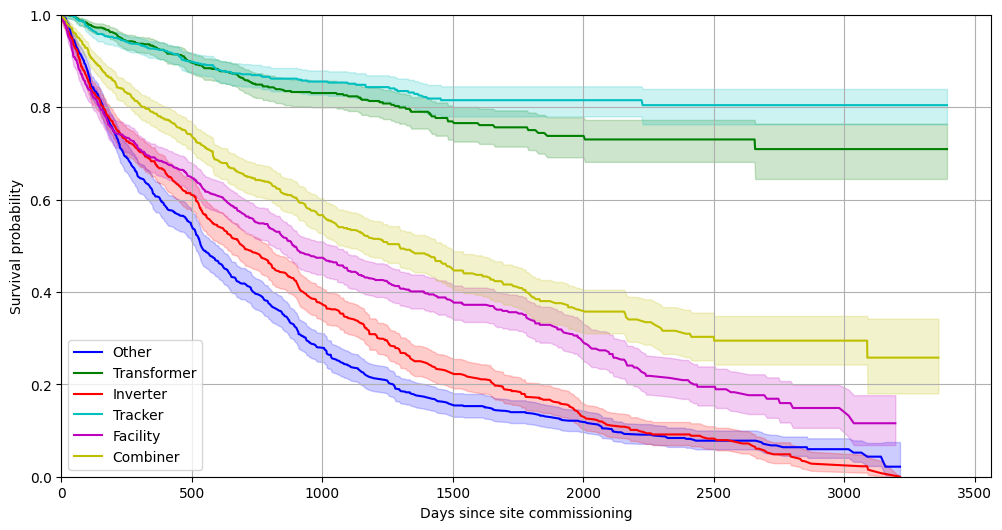

In [6]:
plt.figure(figsize=(12,6))
assets = om_df['Asset'].unique()
colors = list(plt.cm.colors.BASE_COLORS.values())[:len(assets)]

for asset, color in zip(assets, colors):
    result = kaplan_meier_results[asset]
    plt.plot(result['times'], result['fail_prob'], color=color, label=asset)
    plt.fill_between(result['times'], result['conf_int'][0], result['conf_int'][1], color=color, alpha=0.2)

plt.legend();
plt.grid();
plt.xlim(0,None);
plt.ylim(0,1);
plt.xlabel('Days since site commissioning')
plt.ylabel('Survival probability');

### Weibull distribution fitting

The Weibull distribution describes a family of probability distributions parametrized by a _shape_ parameter and a _scale_ parameter. It is frequently used to model the probability of failure by fitting its parameters to observed data. As a parametric method, it is less flexible than the nonparametric Kaplan-Meier estimation but is simpler and potentially easier to interpret.

The `models.survival.fit_survival_function` in the `pvops.timeseries` module implements the Weibull fitting when `method=weibull'` is used, shown below.

In [ ]:
col_dict = {'group_by': 'Asset', 'time_to_fail': 'days_until_failure', 'was_observed': 'was_observed'}
weibull_results = timeseries.models.survival.fit_survival_function(censored_om_df, col_dict, method='weibull')

And we can plot the Weibull results as well:

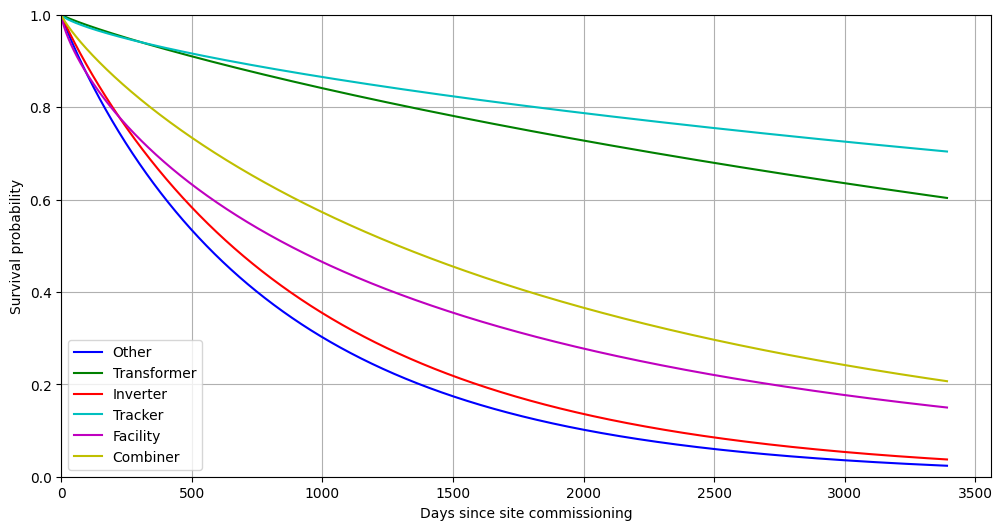

In [8]:
plt.figure(figsize=(12,6))
assets = om_df['Asset'].unique()
colors = list(plt.cm.colors.BASE_COLORS.values())[:len(assets)]
days = range(censored_om_df['days_until_failure'].max())

for asset, color in zip(assets, colors):
    fitted_weibull = weibull_results[asset]['distribution']
    weibull_probs = fitted_weibull.sf(days)
    plt.plot(days, weibull_probs, color=color, label=asset)

plt.legend();
plt.grid();
plt.xlim(0,None);
plt.ylim(0,1);
plt.xlabel('Days since site commissioning')
plt.ylabel('Survival probability');

We can also extract the coefficients and format them into a table for analysis:

In [9]:
parameters = [list(series.values())[:-1] for series in weibull_results.values()]
param_df = pd.DataFrame(parameters, index=weibull_results.keys(), columns=['shape', 'scale'])
param_df

,shape,scale
Other,0.932064,823.962180
Transformer,0.875983,7396.679666
Inverter,0.943692,961.246107
Tracker,0.724652,14380.096078
Facility,0.742765,1430.950715
Combiner,0.850317,1986.362160


We can see that all asset types have shape parameters < 1, indicating the rates of failure decreases over time for all asset types. Inverters see the slowest reduction in failure rate, while trackers have the fastest.